In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/MLG_Project_Code/')

## Install Dependencies


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math

# Task
Implement and explain the GRU-D model using the data described in "/content/DATA_PREPROCESSING.md" and the code in "/content/GRUD_mean.ipynb".

## Understand the data and gru-d concept

### Subtask:
Analyze the provided files ("DATA_PREPROCESSING.md" and "GRUD_mean.ipynb") to understand the data format and the existing GRU-D implementation or related code. Research GRU-D to fully grasp its architecture and purpose.


**Reasoning**:
Read the contents of the "DATA_PREPROCESSING.md" and "GRUD_mean.ipynb" files to understand the data format, preprocessing, and existing code, then perform research on the GRU-D model.



In [5]:
def load_data(split_type):
  data = torch.load(f'processed/{split_type}.pt')
  return data

In [6]:
train_data = load_data('train')
val_data = load_data('val')
test_data = load_data('test')

In [ ]:
train_data[0], train_data[1]

In [ ]:
val_data[0], val_data[1]

In [ ]:
test_data[0], test_data[1]

##Data Processing to Fit GRU-D Architecture

##Break down of the Output Shapes:

1. hist_data_grud (batch_size, 3, n_features, seq_len):
  - batch_size: This is the number of patient records in a single batch that the GRU-D model will process simultaneously. This dimension is added when you use a DataLoader to group your data.
  - 3: This dimension represents the three essential components required by the GRU-D cell for each observation:
    - Index 0: The actual observed data values (hist_vals).
    - Index 1: The mask (hist_mask) indicating which values are observed (typically 1) and which are missing (typically 0).
    - Index 2: The delta (hist_delta), which is the time difference since the last observation for each feature.
  - n_features: This is the number of different features or variables being measured for each patient (e.g., heart rate, blood pressure, temperature, etc.).
  - seq_len: This is the maximum length of the history sequences within the current batch after padding. Since patient records have different numbers of observations, padding is necessary to make all sequences in a batch the same length.
    - The data is structured as (batch_size, 3, n_features, seq_len) to align with how the GRUD_cell is implemented, where it iterates through the sequence length dimension (seq_len) at each step, processing the data, mask, and delta for all features (n_features) in the batch (batch_size).
2. hist_lengths (batch_size,):
batch_size -> number of patient records in the batch.
(,): indicates a 1-dimensional tensor. Each element in this tensor stores the original (unpadded) length of the history sequence for the corresponding patient in the batch.
- This information is crucial when working with padded sequences, as you may need to know the true length of each sequence (e.g., for packing padded sequences or calculating loss only on actual data points).
3. forecast_targets (batch_size, forecast_seq_len, n_features):
- forecast_seq_len: This is the maximum length of the forecasting period sequences within the current batch after padding. Similar to seq_len for history, padding is applied to make all forecast sequences in a batch the same length.
- n_features: The number of features being forecasted.
4. forecast_masks (batch_size, forecast_seq_len, n_features):
batch_size, forecast_seq_len, n_features: These dimensions match the forecast_targets. This mask indicates which values in the forecast_targets tensor are actual observed values in the forecasting period (1) and which are padded or missing (0).
- This mask is essential for calculating the loss only on the actual observed forecast values and ignoring the padded ones.

In [10]:
import torch
from torch.nn.utils.rnn import pad_sequence

def data_gru_d(data):
    """
    Adapts patient data for GRU-D input and extracts forecasting targets.

    Args:
        data: A list of patient records, where each record is a tuple
                  (record_id, tt, vals, mask).

    Returns:
        A tuple containing:
            - hist_data_grud: Padded tensor for GRU-D history input
                              (batch_size, 3, n_features, seq_len).
                              The second dimension contains (data, mask, delta).
            - hist_lengths: Tensor of history sequence lengths (batch_size,).
            - forecast_targets: Padded tensor of forecasting targets
                               (batch_size, forecast_seq_len, n_features).
            - forecast_masks: Padded tensor of forecasting target masks
                              (batch_size, forecast_seq_len, n_features).
    """
    batch_hist_data = []
    batch_hist_mask = []
    batch_hist_delta = []
    batch_hist_lengths = []

    batch_forecast_targets = []
    batch_forecast_masks = []

    for record_id, tt, vals, mask in data:
        # Split history (0-24hr) and forecast (24-30hr)
        # Normalized: 24/48 = 0.5, 30/48 = 0.625
        history_mask = tt <= 0.5
        forecast_mask_tt = (tt > 0.5) & (tt <= 0.625)

        # History data for GRU-D
        hist_tt = tt[history_mask]
        hist_vals = vals[history_mask]
        hist_mask = mask[history_mask]

        # Calculate delta for GRU-D
        # Delta is the time difference between consecutive observations
        hist_delta = torch.cat([torch.zeros(1, device=tt.device), hist_tt[1:] - hist_tt[:-1]])


        batch_hist_data.append(hist_vals)
        batch_hist_mask.append(hist_mask)
        batch_hist_delta.append(hist_delta)
        batch_hist_lengths.append(len(hist_tt))

        # Forecast targets and masks
        forecast_vals = vals[forecast_mask_tt]
        forecast_mask_vals = mask[forecast_mask_tt]

        batch_forecast_targets.append(forecast_vals)
        batch_forecast_masks.append(forecast_mask_vals)

    # Pad sequences for history data
    # These will have shape (B, T, D) where T is max_seq_len, D is n_features
    padded_hist_data = pad_sequence(batch_hist_data, batch_first=True)
    padded_hist_mask = pad_sequence(batch_hist_mask, batch_first=True)
    padded_hist_delta = pad_sequence(batch_hist_delta, batch_first=True) # (B, T)


    # Pad sequences for forecast data
    padded_forecast_targets = pad_sequence(batch_forecast_targets, batch_first=True) # (B, T_forecast, D)
    padded_forecast_masks = pad_sequence(batch_forecast_masks, batch_first=True) # (B, T_forecast, D)

    # Transpose padded history tensors to get feature dimension before sequence length
    # GRUD_cell expects input shape (batch_size, 3, input_size, seq_len)
    padded_hist_data_t = padded_hist_data.transpose(1, 2) # (B, D, T)
    padded_hist_mask_t = padded_hist_mask.transpose(1, 2) # (B, D, T)

    # Repeat delta across feature dimension to match (B, D, T) shape for stacking
    # padded_hist_delta is (B, T)
    # Need to unsqueeze feature dim (dim=1) and repeat it D times (D is padded_hist_data_t.size(1))
    padded_hist_delta_repeated = padded_hist_delta.unsqueeze(1).repeat(1, padded_hist_data_t.size(1), 1) # (B, D, T)


    # Combine data, mask, and delta for GRU-D input format (B, 3, D, T)
    hist_data_grud = torch.stack([padded_hist_data_t, padded_hist_mask_t, padded_hist_delta_repeated], dim=1)


    hist_lengths = torch.tensor(batch_hist_lengths)

    return hist_data_grud, hist_lengths, padded_forecast_targets, padded_forecast_masks

##GRU-D Model Implementation

Made minor changes of code from this repo: https://github.com/fteufel/PyTorch-GRU-D/blob/master/src/GRUD_model.py


In [ ]:
train_grud_data = data_gru_d(train_data)
val_grud_data = data_gru_d(val_data)
test_grud_data = data_gru_d(test_data)

print(train_grud_data[0].size())
print(train_grud_data[0])

print(train_grud_data[1].size())
print(train_grud_data[1])

print(train_grud_data[2].size())
print(train_grud_data[2])

print(train_grud_data[3].size())
print(train_grud_data[3])

## Set up data loaders

### Subtask:
Create PyTorch DataLoaders for the training, validation, and testing datasets to handle batching and shuffling.


In [12]:
class GRUDDataset(Dataset):
    def __init__(self, grud_data):
        """
        Custom Dataset for GRU-D data.

        Args:
            grud_data: A tuple containing (hist_data_grud, hist_lengths,
                                         forecast_targets, forecast_masks).
        """
        self.hist_data_grud = grud_data[0]
        self.hist_lengths = grud_data[1]
        self.forecast_targets = grud_data[2]
        self.forecast_masks = grud_data[3]

    def __len__(self):
        return self.hist_data_grud.size(0)

    def __getitem__(self, idx):
        return (self.hist_data_grud[idx],
                self.hist_lengths[idx],
                self.forecast_targets[idx],
                self.forecast_masks[idx])

# Create Dataset instances
train_dataset = GRUDDataset(train_grud_data)
val_dataset = GRUDDataset(val_grud_data)
test_dataset = GRUDDataset(test_grud_data)

# Define batch size
batch_size = 64

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train DataLoader created with batch size:", batch_size)
print("Validation DataLoader created with batch size:", batch_size)
print("Test DataLoader created with batch size:", batch_size)

Train DataLoader created with batch size: 64
Validation DataLoader created with batch size: 64
Test DataLoader created with batch size: 64


## Instantiate the model, loss function, and optimizer

### Subtask:
Instantiate the `MultiLayerGRUD` model, define a suitable loss function (e.g., Mean Squared Error), and choose an optimizer (e.g., Adam).


In [13]:
class GRUD_cell(torch.nn.Module):
    """
    Implementation of GRUD.
    Inputs: x_mean
            n_smp x 3 x n_channels x len_seq tensor (0: data, 1: mask, 2: deltat)
    """
    def __init__(self, input_size, hidden_size, output_size, x_mean=0,\
                 bias=True, batch_first=True, bidirectional=False, dropout=0, return_hidden = False):

        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")

        super(GRUD_cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.return_hidden = return_hidden

        x_mean = torch.tensor(x_mean, dtype=torch.float32)
        self.register_buffer('x_mean', x_mean)
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.w_dg_x = torch.nn.Linear(input_size,input_size, bias=True)
        self.w_dg_h = torch.nn.Linear(input_size, hidden_size, bias = True)

        self.w_xz = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.w_hz = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.w_mz = torch.nn.Linear(input_size, hidden_size, bias=True)

        self.w_xr = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.w_hr = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.w_mr = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.w_xh = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.w_hh = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.w_mh = torch.nn.Linear(input_size, hidden_size, bias=True)

        self.w_hy = torch.nn.Linear(hidden_size, output_size, bias=True)

        self.dropout_layer = nn.Dropout(p=self.dropout)

        Hidden_State = torch.zeros(self.hidden_size)
        self.register_buffer('Hidden_State', Hidden_State)

        X_last_obs = torch.zeros(input_size)
        self.register_buffer('X_last_obs', X_last_obs)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size ** 0.5)
        for weight in self.parameters():
            if weight.requires_grad:
                 torch.nn.init.uniform_(weight, -stdv, stdv)

    def extra_repr(self):
        s = 'input_size={input_size}, hidden_size={hidden_size}, output_size={output_size}'
        if self.bias is not True:
            s += ', bias={bias}'
        if self.batch_first is not True:
            s += ', batch_first={batch_first}'
        if self.dropout != 0:
            s += ', dropout={dropout}'
        if self.bidirectional is not False:
            s += ', bidirectional={bidirectional}'
        s += ', return_hidden={return_hidden}'
        return s.format(**self.__dict__)

    @property
    def _flat_weights(self):
        return [p for p in self._parameters.values() if p.requires_grad]

    def forward(self, input):
        # input.size = (batch_size, 3, input_size, seq_len)

        input = input.to(dtype=torch.float32)

        x = input[:,0,:,:] # (batch_size, input_size, seq_len)
        mask = input[:,1,:,:] # (batch_size, input_size, seq_len)
        delta = input[:,2,:,:] # (batch_size, input_size, seq_len)

        batch_size, input_size, seq_len = x.size()

        device = input.device
        h = self.Hidden_State.unsqueeze(0).repeat(batch_size, 1).to(device) # (batch_size, hidden_size)
        x_last_obsv = self.X_last_obs.unsqueeze(0).repeat(batch_size, 1).to(device) # (batch_size, input_size)
        x_mean = self.x_mean.unsqueeze(0).repeat(batch_size, 1).to(device) # (batch_size, input_size)


        output_tensor = torch.empty([batch_size, seq_len, self.output_size], dtype=x.dtype, device= device)
        hidden_tensor = torch.empty(batch_size, seq_len, self.hidden_size, dtype=x.dtype, device = device)

        for timestep in range(seq_len):

            x_t = torch.squeeze(x[:,:,timestep]) # (batch_size, input_size)
            m_t = torch.squeeze(mask[:,:,timestep]) # (batch_size, input_size)
            d_t = torch.squeeze(delta[:,:,timestep]) # (batch_size, input_size)


            gamma_x = torch.exp(-torch.relu( self.w_dg_x(d_t) )) # (batch_size, input_size)
            gamma_h = torch.exp(-torch.relu( self.w_dg_h(d_t) )) # (batch_size, hidden_size)

            x_last_obsv = torch.where(m_t.bool(), x_t, x_last_obsv) # (batch_size, input_size)

            x_imputed = m_t * x_t + (1 - m_t) * (gamma_x * x_last_obsv + (1 - gamma_x) * x_mean) # (batch_size, input_size)

            h_decayed = gamma_h * h # (batch_size, hidden_size)

            z = torch.sigmoid(self.w_xz(x_imputed) + self.w_hz(h_decayed) + self.w_mz(m_t)) # (batch_size, hidden_size)
            r = torch.sigmoid(self.w_xr(x_imputed) + self.w_hr(h_decayed) + self.w_mr(m_t)) # (batch_size, hidden_size)

            h_tilde = torch.tanh( self.w_xh(x_imputed) + self.w_hh( r * h_decayed ) + self.w_mh(m_t)) # (batch_size, hidden_size)

            h = (1 - z) * h_decayed + z * h_tilde # (batch_size, hidden_size)

            if self.dropout > 0 and self.training:
                 h = self.dropout_layer(h)

            step_output = self.w_hy(h) # (batch_size, output_size)

            if not self.return_hidden:
                 step_output = torch.sigmoid(step_output)

            output_tensor[:,timestep,:] = step_output
            hidden_tensor[:,timestep,:] = h

        if self.return_hidden:
            output = hidden_tensor # (batch_size, seq_len, hidden_size)
        else:
            output = output_tensor # (batch_size, seq_len, output_size)

        final_hidden_state = h

        return output, final_hidden_state

In [14]:
class MultiLayerGRUD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, x_mean=0, num_layers=1, dropout=0):
        super(MultiLayerGRUD, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.grud_layers = nn.ModuleList()

        for i in range(num_layers):
            in_size = input_size if i == 0 else hidden_size
            out_size = hidden_size if i < num_layers - 1 else hidden_size
            if i == 0:
                layer_x_mean = x_mean  # original (41,) mean vector
            else:
                # deeper layers process hidden features → use zeros of matching size
                layer_x_mean = torch.zeros(in_size)

            self.grud_layers.append(
                GRUD_cell(
                    input_size=in_size,
                    hidden_size=hidden_size,
                    output_size=out_size,
                    x_mean=layer_x_mean,  # ✅ each layer gets correctly sized mean
                    dropout=dropout,
                    return_hidden=True
                )
            )

        # Forecasting head stays the same
        self.forecast_head = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, forecast_seq_len=6):
      # x: (B, 3, n_features, seq_len)
      out, h = x, None
      original_mask = x[:, 1, :, :]
      original_delta = x[:, 2, :, :]

      for i, layer in enumerate(self.grud_layers):
          out, h = layer(out)  # out: (B, seq_len, hidden_size)
          out = out.transpose(1, 2)  # (B, hidden_size, seq_len)

          if i < len(self.grud_layers) - 1:
              # Prepare mask & delta for next layer (size match hidden_size)
              B, D_hidden, T = out.shape
              D_original = original_mask.size(1)

              # Repeat mask & delta cyclically to match hidden size
              mask_expanded = torch.zeros(B, D_hidden, T, device=x.device)
              delta_expanded = torch.zeros(B, D_hidden, T, device=x.device)

              for j in range(D_hidden):
                  feature_idx = j % D_original
                  mask_expanded[:, j, :] = original_mask[:, feature_idx, :]
                  delta_expanded[:, j, :] = original_delta[:, feature_idx, :]

              out = torch.stack([out, mask_expanded, delta_expanded], dim=1)
          else:
              # last layer output: (B, seq_len, hidden_size)
              pass

      # Final hidden state used for forecasting
      h = h.unsqueeze(0)
      dec_input = torch.zeros(x.size(0), forecast_seq_len, self.hidden_size, device=x.device)
      dec_out, _ = self.forecast_head(dec_input, h)
      forecast = self.out_layer(dec_out)  # (B, forecast_seq_len, output_size)
      return forecast

**Reasoning**:
Instantiate the MultiLayerGRUD model, define the loss function, and choose the optimizer.



In [ ]:
# Define model parameters
num_total_features = 41
num_temporal_features = 36
temporal_start = num_total_features - num_temporal_features
temporal_idx = slice(temporal_start, num_total_features)

input_size = num_total_features
output_size = num_temporal_features
hidden_size = 128

num_layers = 2

# Calculate the mean of the training data for imputation for the *first* layer
# train_grud_data[0] is (batch_size, 3, n_features, seq_len) -> now (batch_size, 3, 128, seq_len) after fixing data_gru_d
# train_grud_data[0][:, 0, :, :] is the data (batch_size, n_features, seq_len) -> (batch_size, 128, seq_len)
# train_grud_data[0][:, 1, :, :] is the mask (batch_size, n_features, seq_len) -> (batch_size, 128, seq_len)

# Mask the data to only include observed values and calculate the mean per feature
# Flatten the batch and sequence length dimensions

x_data = train_grud_data[0][:, 0, :, :]   # observed values (B, D, T)
x_mask = train_grud_data[0][:, 1, :, :]   # mask (B, D, T)

# Sum of observed values per feature / number of observed values per feature
x_sum = (x_data * x_mask).sum(dim=(0, 2))   # (D,)
x_count = x_mask.sum(dim=(0, 2))            # (D,)
x_mean = x_sum / torch.clamp(x_count, min=1)  # mean for each feature (D,)


# Instantiate the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiLayerGRUD(input_size=input_size, # Correct input size for the first layer (should be 128)
                       hidden_size=hidden_size,
                       output_size=output_size,
                       num_layers=num_layers,
                       x_mean=x_mean, # Pass the x_mean tensor directly
                       dropout=0.2).to(device) # Example dropout

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model architecture and optimizer
print("Model Architecture:")
print(model)
print("\nOptimizer:")
print(optimizer)

In [16]:
def calculate_metrics(predicted, actual, mask):
    """
    Calculates MAE, MSE, RMSE, and R2, considering the mask.

    Args:
        predicted: Tensor of predicted values (batch_size, seq_len, n_features).
        actual: Tensor of actual values (batch_size, seq_len, n_features).
        mask: Tensor indicating observed values (batch_size, seq_len, n_features).

    Returns:
        Tuple of (MAE, MSE, RMSE, R2).
    """
    # Apply mask to get only observed values
    predicted_masked = predicted[mask.bool()]
    actual_masked = actual[mask.bool()]

    if actual_masked.numel() == 0:
        # No observed values in this batch/dataset split
        return float('nan'), float('nan'), float('nan'), float('nan')

    # Calculate metrics using numpy for compatibility with sklearn metrics
    predicted_np = predicted_masked.cpu().numpy()
    actual_np = actual_masked.cpu().numpy()

    mae = mean_absolute_error(actual_np, predicted_np)
    mse = mean_squared_error(actual_np, predicted_np)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_np, predicted_np)

    return mae, mse, rmse, r2

## Implement the training and validation loop


In [17]:
def train_or_eval(model, dataloader, criterion, optimizer=None, device="cpu"):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    temporal_start = 5
    temporal_idx = slice(temporal_start, 41)
    total_loss = 0
    all_preds, all_tgts, all_masks = [], [], []
    # print("Forecast target shape:", sample[2].shape)

    with torch.set_grad_enabled(is_train):
        for hist_data, hist_len, forecast_tgt, forecast_mask in dataloader:
            hist_data, forecast_tgt, forecast_mask = hist_data.to(device), forecast_tgt.to(device), forecast_mask.to(device)
            forecast_seq_len = forecast_tgt.size(1)
            preds = model(hist_data, forecast_seq_len)

            # Apply temporal_idx to predictions before loss calculation
            forecast_tgt_temporal = forecast_tgt[:, :, temporal_idx]
            forecast_mask_temporal = forecast_mask[:, :, temporal_idx]

            loss = criterion(preds * forecast_mask_temporal, forecast_tgt_temporal * forecast_mask_temporal)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

            # Store for metrics if validation
            if not is_train:
                all_preds.append(preds.detach().cpu())
                all_tgts.append(forecast_tgt_temporal.cpu())
                all_masks.append(forecast_mask_temporal.cpu())

    avg_loss = total_loss / len(dataloader)

    # If validation → compute metrics
    if not is_train:
        all_preds = torch.cat(all_preds)
        all_tgts = torch.cat(all_tgts)
        all_masks = torch.cat(all_masks)

        # The slicing is now done inside the loop, so no need to do it again here.
        # all_tgts = all_tgts[:, :, temporal_idx]
        # all_masks = all_masks[:, :, temporal_idx]

        mae, mse, rmse, r2 = calculate_metrics(all_preds, all_tgts, all_masks)
        return avg_loss, mae, mse, rmse, r2
    else:
        return avg_loss

In [18]:
num_epochs = 10
train_losses = []
val_losses = []
val_maes = []
val_mses = []
val_rmses = []
val_r2s = []

for epoch in range(num_epochs):
    train_loss = train_or_eval(model, train_loader, criterion, optimizer, device)
    val_loss, val_mae, val_mse, val_rmse, val_r2 = train_or_eval(model, val_loader, criterion, None, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_mses.append(val_mse)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")
    print(f"  Val Metrics: MAE={val_mae:.4f}, MSE={val_mse:.4f}, RMSE={val_rmse:.4f}, R²={val_r2:.4f}")

Epoch 1/10
  Train Loss: 0.0226
  Val   Loss: 0.0172
  Val Metrics: MAE=0.5175, MSE=0.5703, RMSE=0.7552, R²=0.3182
Epoch 2/10
  Train Loss: 0.0193
  Val   Loss: 0.0164
  Val Metrics: MAE=0.5018, MSE=0.5418, RMSE=0.7360, R²=0.3523
Epoch 3/10
  Train Loss: 0.0184
  Val   Loss: 0.0157
  Val Metrics: MAE=0.4845, MSE=0.5178, RMSE=0.7196, R²=0.3809
Epoch 4/10
  Train Loss: 0.0179
  Val   Loss: 0.0153
  Val Metrics: MAE=0.4764, MSE=0.5072, RMSE=0.7122, R²=0.3936
Epoch 5/10
  Train Loss: 0.0174
  Val   Loss: 0.0150
  Val Metrics: MAE=0.4683, MSE=0.4945, RMSE=0.7032, R²=0.4088
Epoch 6/10
  Train Loss: 0.0171
  Val   Loss: 0.0147
  Val Metrics: MAE=0.4650, MSE=0.4860, RMSE=0.6971, R²=0.4190
Epoch 7/10
  Train Loss: 0.0168
  Val   Loss: 0.0146
  Val Metrics: MAE=0.4619, MSE=0.4817, RMSE=0.6940, R²=0.4241
Epoch 8/10
  Train Loss: 0.0166
  Val   Loss: 0.0144
  Val Metrics: MAE=0.4585, MSE=0.4771, RMSE=0.6907, R²=0.4296
Epoch 9/10
  Train Loss: 0.0164
  Val   Loss: 0.0143
  Val Metrics: MAE=0.4564, 

In [19]:
temporal_start = 5
temporal_idx = slice(temporal_start, None)
model.eval()
with torch.no_grad():
    all_preds, all_tgts, all_masks = [], [], []
    for hist_data, hist_len, forecast_tgt, forecast_mask in test_loader:
        hist_data, forecast_tgt, forecast_mask = hist_data.to(device), forecast_tgt.to(device), forecast_mask.to(device)
        preds = model(hist_data, forecast_tgt.size(1))
        all_preds.append(preds.cpu())
        all_tgts.append(forecast_tgt.cpu())
        all_masks.append(forecast_mask.cpu())

preds = torch.cat(all_preds)
tgts = torch.cat(all_tgts)
masks = torch.cat(all_masks)

tgts = tgts[:, :, temporal_idx]
masks = masks[:, :, temporal_idx]

mae, mse, rmse, r2 = calculate_metrics(preds, tgts, masks)
print(f"\nTest MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


Test MAE=0.4560, MSE=0.5361, RMSE=0.7322, R2=0.4099


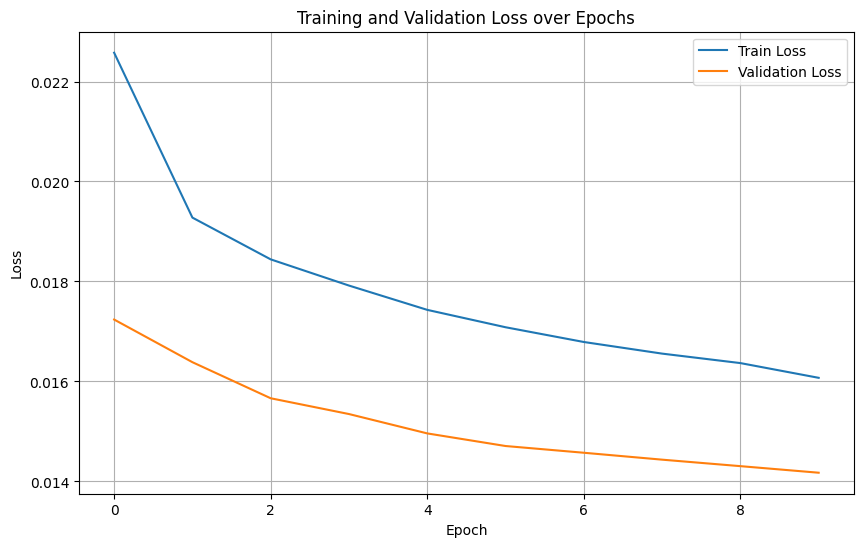

In [20]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

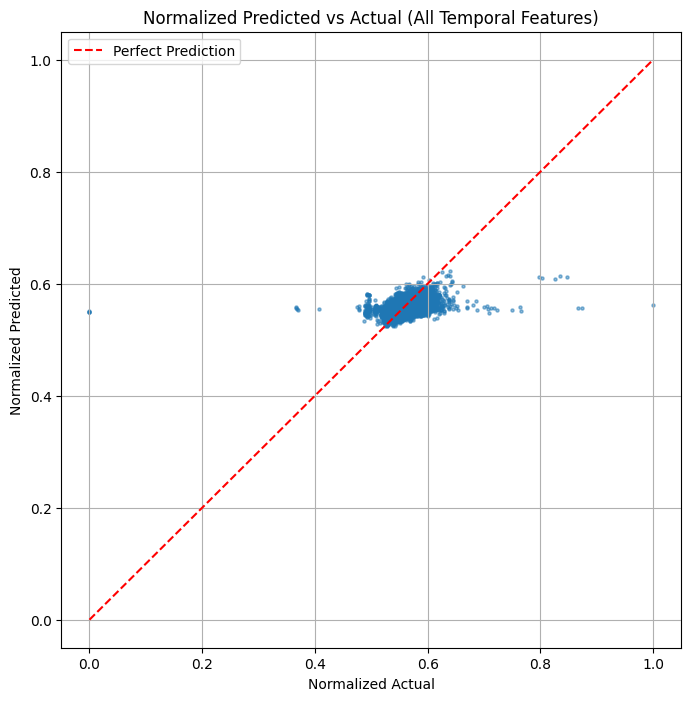

In [21]:
# Plotting prediction vs actual for all temporal features from the test set on a normalized scale
temporal_start = 5
temporal_idx = slice(temporal_start, None)

# Ensure model is in eval mode
model.eval()
with torch.no_grad():
    all_preds, all_tgts, all_masks = [], [], []
    for hist_data, hist_len, forecast_tgt, forecast_mask in test_loader:
        hist_data, forecast_tgt, forecast_mask = hist_data.to(device), forecast_tgt.to(device), forecast_mask.to(device)
        preds = model(hist_data, forecast_tgt.size(1))

        # Apply temporal_idx to get only temporal features
        forecast_tgt_temporal = forecast_tgt[:, :, temporal_idx]
        forecast_mask_temporal = forecast_mask[:, :, temporal_idx]
        preds_temporal = preds # Predictions already match the temporal feature output size

        all_preds.append(preds_temporal.cpu())
        all_tgts.append(forecast_tgt_temporal.cpu())
        all_masks.append(forecast_mask_temporal.cpu())

preds = torch.cat(all_preds)
tgts = torch.cat(all_tgts)
masks = torch.cat(all_masks)

# Flatten the batch and sequence length for easier plotting
preds_flat = preds.view(-1)
tgts_flat = tgts.view(-1)
masks_flat = masks.view(-1)

# Filter out padded values using the mask
preds_observed = preds_flat[masks_flat.bool()]
tgts_observed = tgts_flat[masks_flat.bool()]

# Normalize the observed data
# Calculate min and max across all observed temporal features
min_val = min(tgts_observed.min(), preds_observed.min())
max_val = max(tgts_observed.max(), preds_observed.max())

# Normalize
if max_val - min_val > 1e-8: # Avoid division by zero
    preds_normalized = (preds_observed - min_val) / (max_val - min_val)
    tgts_normalized = (tgts_observed - min_val) / (max_val - min_val)
else:
    # If all values are the same, normalized values are all 0 or 1
    preds_normalized = torch.zeros_like(preds_observed)
    tgts_normalized = torch.zeros_like(tgts_observed)


plt.figure(figsize=(8, 8))
plt.scatter(tgts_normalized.numpy(), preds_normalized.numpy(), alpha=0.5, s=5)
plt.xlabel('Normalized Actual')
plt.ylabel('Normalized Predicted')
plt.title('Normalized Predicted vs Actual (All Temporal Features)')
# Add a line for perfect prediction
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.legend()
plt.grid(True)
plt.show()

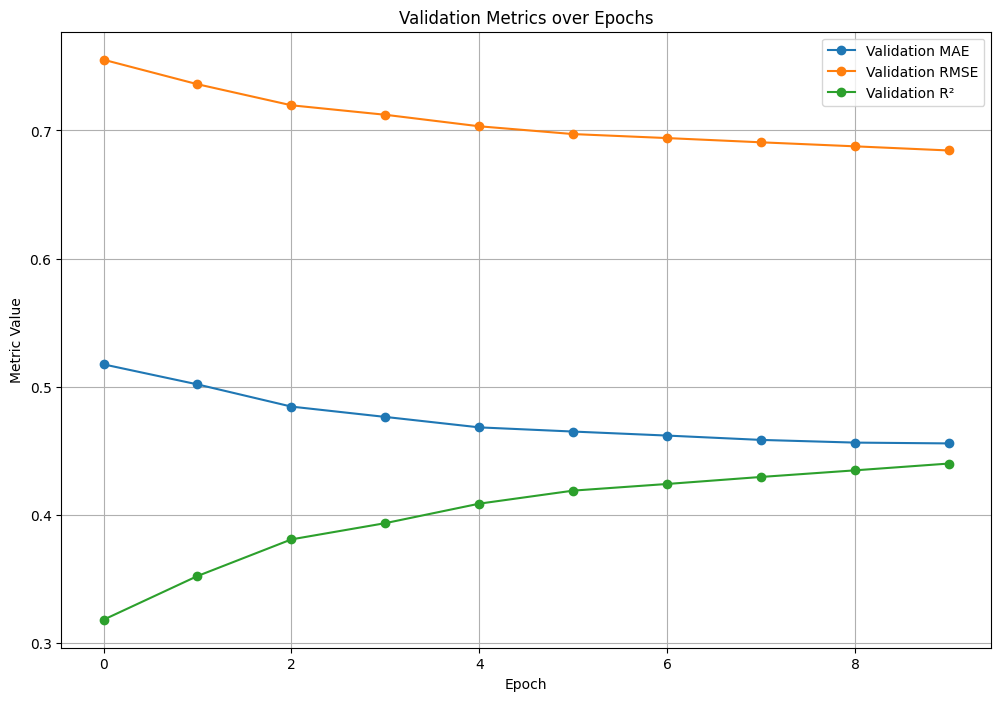

In [22]:
# Plotting validation metrics over epochs
plt.figure(figsize=(12, 8))

plt.plot(range(num_epochs), val_maes, label='Validation MAE', marker='o')
plt.plot(range(num_epochs), val_rmses, label='Validation RMSE', marker='o')
plt.plot(range(num_epochs), val_r2s, label='Validation R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Next Steps:
1. Complete Hyperparamter Tuning on the Number of Epochs. Learning Rate, Num of Layers, Batch Size